### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（步骤7：信贷评分卡模型在线监控）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.18</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") # 忽略警告
from sklearn.model_selection import train_test_split
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.metrics import confusion_matrix,recall_score, auc, roc_curve,precision_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号\
matplotlib.rcParams['font.size']=15       
%matplotlib inline

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学）  

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据
将数据分为data_train（训练集）和 data_test（测试集）两部分，其中训练集占总数据量80%，即800条样本数据，测试集占20%，即200条样本数据，两个数据集均通过随机抽取得到。 

In [2]:
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    # 将标签变量由状态1,2转为0,1; 其中0表示好信用，1表示坏信用
    df.target = df.target - 1
    # 将数据分为data_train（训练集）和 data_test（测试集）两部分
    # 按目标变量进行分层抽样，即训练集和测试集中，好坏样本的比例相同。
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target) 
    # 由于训练集、测试集是随机划分，索引是乱的，需要重新排序
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\lotbear\\Desktop\\Data-science！','金融风控实战数据')
    file_name = 'german.csv'
    # 读取数据
    data_train, data_test = data_read(data_path,file_name)
    # 区分离散变量与连续变量
    feature_names = list(data_train.columns)
    feature_names.remove('target')

### 第三步：区分离散/连续变量

In [3]:
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    # 先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float',
                                                                  'int32','float32',
                                                                  'int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

In [4]:
categorical_var,numerical_var = category_continue_separation(data_train,feature_names)
feature_names = list(data_train.columns)
feature_names.remove('target')
categorical_var,numerical_var = category_continue_separation(data_train,feature_names)
print('初始7个连续变量：','\n',numerical_var)
print('='*80)
print('初始连续变量情况：')
# 对于取值小于10种数值的连续型变量，改为离散变量，且将数值转化为字符串
for s in set(numerical_var):
    print('变量'+s+'可能取值'+str(len(data_train[s].unique())))
    if len(data_train[s].unique())<=10:
        categorical_var.append(s)
        numerical_var.remove(s)
        # 同时将后加的数值变量转为字符串
        # 先用bool数值将变量取值中空值标注成 FALSE（0）
        index_1 = data_train[s].isnull()
        # 如果变量中有空值，则对非空值进行字符串转化
        if sum(index_1) > 0:
            data_train.loc[~index_1,s] = data_train.loc[~index_1,s].astype('str')
        # 如果变量中没有空值，则直接进行字符串转化
        else:
            data_train[s] = data_train[s].astype('str')
        index_2 = data_test[s].isnull()
        if sum(index_2) > 0:
            data_test.loc[~index_2,s] = data_test.loc[~index_2,s].astype('str')
        else:
            data_test[s] = data_test[s].astype('str')

print('='*80)
print('经转换后，剩余连续变量：','\n',numerical_var)
print('='*80)
print('离散变量：','\n',categorical_var)

初始7个连续变量： 
 ['duration', 'amount', 'income_rate', 'residence_info', 'age', 'num_credits', 'dependents']
初始连续变量情况：
变量amount可能取值744
变量duration可能取值30
变量num_credits可能取值4
变量dependents可能取值2
变量income_rate可能取值4
变量residence_info可能取值4
变量age可能取值53
经转换后，剩余连续变量： 
 ['duration', 'amount', 'age']
离散变量： 
 ['status_account', 'credit_history', 'purpose', 'svaing_account', 'present_emp', 'personal_status', 'other_debtors', 'property', 'inst_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'num_credits', 'dependents', 'income_rate', 'residence_info']


### 第四步：变量分箱

In [5]:
# 连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

# 离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3,
                                     mmax=8, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]
        
print('删除分箱数只有单个的变量：','共',len(del_key),'个')
print(del_key)

### 训练集数据分箱

# 连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , 
                                   varbin_meth.cont_var_bin_map(data_train[i], 
                                   dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , 
                                   varbin_meth.disc_var_bin_map(data_train[i], 
                                   dict_disc_bin[i]) ], axis = 1)

### 测试集数据分箱
# 连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , 
                                varbin_meth.cont_var_bin_map(data_test[i], 
                                dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , 
                                  varbin_meth.disc_var_bin_map(data_test[i], 
                                  dict_disc_bin[i]) ], axis = 1)

### 组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

print('='*80)
print('训练集18个变量分箱结果：')
data_train_bin

删除分箱数只有单个的变量： 共 2 个
['other_debtors', 'foreign_worker']
训练集18个变量分箱结果：


,duration_BIN,amount_BIN,age_BIN,status_account_BIN,credit_history_BIN,purpose_BIN,svaing_account_BIN,present_emp_BIN,personal_status_BIN,property_BIN,inst_plans_BIN,housing_BIN,job_BIN,telephone_BIN,num_credits_BIN,dependents_BIN,income_rate_BIN,residence_info_BIN,target
0,5,2,7,2,1,4,1,2,1,1,1,1,2,2,1,2,4,2,0
1,5,5,5,2,4,2,2,2,2,2,2,1,2,1,1,2,3,2,0
2,5,2,6,1,1,4,3,3,2,1,1,1,2,1,1,2,4,4,0
3,6,2,3,1,4,4,3,3,1,2,1,1,2,2,1,2,4,4,0
4,2,1,10,3,1,4,3,2,1,1,1,1,1,2,1,2,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,2,3,2,1,4,1,3,1,2,2,1,2,2,2,2,2,2,0
796,2,2,3,3,2,4,3,4,1,4,1,2,3,1,2,2,3,4,1
797,3,2,8,1,1,2,1,2,2,1,1,1,2,1,1,2,4,4,0
798,5,3,1,2,1,3,1,2,1,4,1,3,2,2,1,2,4,2,0


### 第五步：对分箱后的数据，进行WOE编码

In [6]:
# WOE编码
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

# 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,
                                var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')

# 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, 
                                                  data_test_bin.target, 'dict_woe_map',flag='test')

print('训练集WOE编码:')
df_train_woe[var_woe_name]

训练集WOE编码:


,duration_BIN_woe,amount_BIN_woe,age_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe,num_credits_BIN_woe,dependents_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe
0,-0.010152,-0.254159,-0.762140,0.301308,-0.824988,0.393733,-0.730888,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.001890,0.090026,-0.108214,0.01138,0.122148,-0.043675
1,-0.010152,-0.538997,-0.123481,0.301308,1.326871,-0.656780,0.135802,-0.244884,0.204582,0.012270,0.534206,-0.171998,-0.001890,-0.136336,-0.108214,0.01138,-0.041594,-0.043675
2,-0.010152,-0.254159,0.211309,-1.138115,-0.824988,0.393733,0.250611,-0.005277,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,-0.108214,0.01138,0.122148,0.098752
3,0.746493,-0.254159,-0.060259,-1.138115,1.326871,0.393733,0.250611,-0.005277,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,0.090026,-0.108214,0.01138,0.122148,0.098752
4,-0.762140,0.431137,-0.370098,0.792238,-0.824988,0.393733,0.250611,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.136434,0.090026,-0.108214,0.01138,0.122148,-0.043675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.311939,-0.254159,-0.060259,0.301308,-0.824988,0.393733,-0.730888,-0.005277,-0.175031,0.012270,0.534206,-0.171998,-0.001890,0.090026,0.058841,0.01138,-0.126151,-0.043675
796,-0.762140,-0.254159,-0.060259,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,0.448659,-0.151537,0.292301,0.154151,-0.136336,0.058841,0.01138,-0.041594,0.098752
797,-0.311939,-0.254159,-0.405465,-1.138115,-0.824988,-0.656780,-0.730888,-0.244884,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,-0.108214,0.01138,0.122148,0.098752
798,-0.010152,-0.604954,0.441833,0.301308,-0.824988,0.017575,-0.730888,-0.244884,-0.175031,0.448659,-0.151537,0.465930,-0.001890,0.090026,-0.108214,0.01138,0.122148,-0.043675


In [7]:
# 取出训练数据与测试数据
x_train = df_train_woe[var_woe_name]
x_train = np.array(x_train)
y_train = np.array(data_train_bin.target)
    
x_test = df_test_woe[var_woe_name]
x_test = np.array(x_test)
y_test = np.array(data_test_bin.target)

### 第六步：logistic回归模型

In [8]:
# 设置优化参数
# C 为正则项惩罚系数（7组）
# class_weight 用字典形式为样本加权，来抑制样本不均衡（3组）
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2], # C值越小，正则强度越高，抑制过拟合作用越强，默认值为0
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]} # 不断增加 坏样本 的拟合权重

# 初始化网格搜索
# 选择 L2 正则项来抑制过拟合，选择 saga 作为优化算法
# cv=3 进行三折交叉验证，由于有7组超参数 C，3组超参数 class_weight，因此共需3*7*3=63次拟合
lr_gsearch = GridSearchCV(
  estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
  param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)

#执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('LR逻辑回归模型最优得分 {0},\n最优参数{1}'.format(lr_gsearch.best_score_,lr_gsearch.best_params_))

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR逻辑回归模型最优得分 0.6502502330113034,
最优参数{'C': 1, 'class_weight': {1: 3, 0: 1}}


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.9s finished


In [9]:
# 用最优参数，初始化Logistic模型
LR_model_2 = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])

# 训练Logistic模型
LR_model_fit = LR_model_2.fit(x_train, y_train)

In [10]:
# 模型预测
y_pred_train = LR_model_fit.predict(x_train)
y_pred_test = LR_model_fit.predict(x_test)

print('用训练好的LR模型，对测试集target数据进行预测：','\n','target=0 为好信用，target=1 为坏信用')
print('='*80)
print(y_pred_test)
print('='*80)
print('测试集中，坏信用数量:',sum(y_pred_test==1))
print('测试集中，好信用数量:',sum(y_pred_test==0))
print('测试集总样本量:',len(y_pred_test))

用训练好的LR模型，对测试集target数据进行预测： 
 target=0 为好信用，target=1 为坏信用
[1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0]
测试集中，坏信用数量: 89
测试集中，好信用数量: 111
测试集总样本量: 200


In [11]:
#保存模型的参数用于计算评分
var_woe_name.append('intercept')

#提取权重
weight_value = list(LR_model_fit.coef_.flatten())

#提取截距项
weight_value.extend(list(LR_model_fit.intercept_))
dict_params = dict(zip(var_woe_name,weight_value))

# 字典转换为DataFrame
LR_model_params=pd.DataFrame.from_dict(dict_params,orient='index',columns=['变量权重'])
print('LR逻辑回归模型生成的变量权重如下：(权重从高到低降序)')
LR_model_params.sort_values(by='变量权重',ascending=False)

LR逻辑回归模型生成的变量权重如下：(权重从高到低降序)


,变量权重
telephone_BIN_woe,1.362679
residence_info_BIN_woe,1.262486
income_rate_BIN_woe,1.173471
purpose_BIN_woe,0.991535
amount_BIN_woe,0.964332
duration_BIN_woe,0.962847
inst_plans_BIN_woe,0.868588
personal_status_BIN_woe,0.847440
status_account_BIN_woe,0.841672
age_BIN_woe,0.767593


### 第七步：生成评分卡
本例，我们将评分卡输出的分数定位在 330~ 660 区间（芝麻信用分数范围在 350~950 ）      

将LR模型输出的样本概率值转化为分数：   

<center>Score(分数) = A - B * log（P/1-P）     
    
<center>Odds = P/1-P     

<center>其中，P为概率值，A为补偿值，B为刻度，Odds为几率</center>    

In [12]:
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
df_pre_test = pd.DataFrame({'y_score':y_score_test,'y_test':y_test})
print('测试样本的输出概率值 vs 真实分类（0为好信用，1为坏信用）：')
df_pre_test

测试样本的输出概率值 vs 真实分类（0为好信用，1为坏信用）：


,y_score,y_test
0,0.541632,0
1,0.865693,1
2,0.491746,0
3,0.788574,0
4,0.925423,1
...,...,...
195,0.406143,0
196,0.594672,0
197,0.975362,0
198,0.162728,0


In [13]:
# 公式转换函数
def score_params_cal(base_point, odds, PDO):
    # 给定基准分数 base_point、翻倍分数 PDO，确定参数 A、B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 
def myfunc(x):
    return str(x[0])+'_'+str(x[1])

In [14]:
# 生成评分卡函数
def create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin):
    # 假设 Odds 在 1:60 时对应的参考分值为 600 分，分值调整刻度 PDO 为 20，则计算得到分值转化的参数 B = 28.85，A= 481.86。
    params_A,params_B = score_params_cal(base_point=600, odds=1/60, PDO=20)
    # 计算基础分
    base_points = round(params_A - params_B * dict_params['intercept'])
    df_score = pd.DataFrame()
    dict_bin_score = {}
    for k in dict_params.keys():
#        k='duration_BIN'
#        k = 'foreign_worker_BIN'
        if k !='intercept':
            df_temp =  pd.DataFrame([dict_woe_map[k.split(sep='_woe')[0]]]).T
            df_temp.reset_index(inplace=True)
            df_temp.columns = ['bin','woe_val']
            # 计算分值
            df_temp['score'] = round(-params_B*df_temp.woe_val*dict_params[k])
            dict_bin_score[k.split(sep='_BIN')[0]] = dict(zip(df_temp['bin'],df_temp['score']))
            # 连续变量的计算
            if k.split(sep='_BIN')[0] in dict_cont_bin.keys():
                df_1 = dict_cont_bin[k.split(sep='_BIN')[0]]
                df_1['var_name'] = df_1[['bin_low', 'bin_up']].apply(myfunc,axis=1)
                df_1 = df_1[['total', 'var_name']]
                df_temp = pd.merge(df_temp , df_1,on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)
            # 离散变量的计算
            elif k.split(sep='_BIN')[0] in dict_disc_bin.keys():
                df_temp = pd.merge(df_temp , dict_disc_bin[k.split(sep='_BIN')[0]],on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)

    df_score['score_base'] =  base_points 
    return df_score,dict_bin_score,params_A,params_B,base_points

In [15]:
# 计算样本分数函数
def cal_score(df_1,dict_bin_score,dict_cont_bin,dict_disc_bin,base_points):
    # 先对原始数据分箱映射，然后，用分数字典dict_bin_score映射分数，基础分加每项的分数就是最终得分
    df_1.reset_index(drop=True,inplace = True)
    df_all_score = pd.DataFrame()
    # 连续变量
    for i in dict_cont_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score , varbin_meth.cont_var_bin_map(df_1[i], 
                                                                            dict_cont_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    # 离散变量
    for i in dict_disc_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score ,varbin_meth.disc_var_bin_map(df_1[i], 
                                                                            dict_disc_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    
    df_all_score.columns = [x.split(sep='_BIN')[0] for x in list(df_all_score.columns)]
    df_all_score['base_score'] = base_points    
    df_all_score['score'] = df_all_score.apply(sum,axis=1)
    df_all_score['target'] = df_1.target
    return df_all_score

#### <font color=blue>生成评分卡参数</font>

In [16]:
df_score,dict_bin_score,params_A,params_B,score_base = create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin)
print('参数 A 取值:',params_A)
print('='*80)
print('参数 B 取值:',params_B)
print('='*80)
print('基准分数:',score_base)

参数 A 取值: 481.8621880878296
参数 B 取值: 28.85390081777927
基准分数: 476.0


In [17]:
print('全部18个变量，不同取值分箱 bins 所对应的分数：')
var_bin_score = pd.DataFrame(dict_bin_score)
var_bin_score.sort_index()

全部18个变量，不同取值分箱 bins 所对应的分数：


,duration,amount,age,status_account,credit_history,purpose,svaing_account,present_emp,personal_status,property,inst_plans,housing,job,telephone,num_credits,dependents,income_rate,residence_info
1,35.0,-12.0,-10.0,28.0,18.0,-20.0,14.0,8.0,4.0,7.0,4.0,2.0,-0.0,5.0,-3.0,-0.0,6.0,2.0
2,21.0,7.0,-20.0,-7.0,-2.0,19.0,-3.0,5.0,-5.0,-0.0,-13.0,-3.0,-0.0,-4.0,1.0,0.0,4.0,2.0
3,9.0,17.0,1.0,-19.0,-5.0,-1.0,-5.0,0.0,NaN,-3.0,NaN,-5.0,0.0,NaN,NaN,NaN,1.0,1.0
4,-13.0,-16.0,-8.0,NaN,-29.0,-11.0,NaN,-10.0,NaN,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4.0
5,0.0,15.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-21.0,-5.0,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,-28.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <font color=blue>计算样本评分 </font>

In [18]:
# 计算样本评分
df_all = pd.concat([data_train,data_test],axis = 0)
df_all_score = cal_score(df_all,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
print('样本最高分：',df_all_score.score.max())
print('样本最低分：',df_all_score.score.min())
print('样本平均分：',df_all_score.score.mean())
print('样本中位数得分：',df_all_score.score.median())
print('='*80)
print('全部样本的变量得分情况：')
df_all_score

样本最高分： 615.0
样本最低分： 351.0
样本平均分： 487.365
样本中位数得分： 488.0
全部样本的变量得分情况：


,duration,amount,age,status_account,credit_history,purpose,svaing_account,present_emp,personal_status,property,...,housing,job,telephone,num_credits,dependents,income_rate,residence_info,base_score,score,target
0,0.0,7.0,17.0,-7.0,18.0,-11.0,14.0,5.0,4.0,7.0,...,2.0,-0.0,-4.0,-3.0,0.0,-4.0,2.0,476.0,527.0,0
1,0.0,15.0,3.0,-7.0,-29.0,19.0,-3.0,5.0,-5.0,-0.0,...,2.0,-0.0,5.0,-3.0,0.0,1.0,2.0,476.0,468.0,0
2,0.0,7.0,-5.0,28.0,18.0,-11.0,-5.0,0.0,-5.0,7.0,...,2.0,-0.0,5.0,-3.0,0.0,-4.0,-4.0,476.0,510.0,0
3,-21.0,7.0,1.0,28.0,-29.0,-11.0,-5.0,0.0,4.0,-0.0,...,2.0,-0.0,-4.0,-3.0,0.0,-4.0,-4.0,476.0,441.0,0
4,21.0,-12.0,8.0,-19.0,18.0,-11.0,-5.0,5.0,4.0,7.0,...,2.0,-0.0,-4.0,-3.0,0.0,-4.0,2.0,476.0,489.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.0,15.0,3.0,-7.0,-2.0,-11.0,-5.0,8.0,4.0,-0.0,...,2.0,-0.0,-4.0,1.0,0.0,4.0,-4.0,476.0,493.0,0
996,-13.0,15.0,3.0,-7.0,-2.0,-11.0,-3.0,0.0,4.0,-0.0,...,2.0,-0.0,5.0,-3.0,0.0,4.0,-4.0,476.0,470.0,0
997,-21.0,-28.0,-1.0,-19.0,-2.0,-20.0,-5.0,-10.0,-5.0,-0.0,...,2.0,0.0,-4.0,1.0,0.0,4.0,2.0,476.0,374.0,0
998,0.0,7.0,17.0,-7.0,18.0,-11.0,14.0,0.0,-5.0,7.0,...,2.0,-0.0,5.0,-3.0,0.0,4.0,2.0,476.0,530.0,0


#### <font color=blue>评分卡区间分数统计</font>

In [19]:
#分数区间计算
score_bin = np.arange(330,660,30)
good_total = sum(df_all_score.target == 0)
bad_total = sum(df_all_score.target == 1)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    #取出分数区间的样本
    if score_bin[i+1] == 630:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score < score_bin[i+1]) 
    df_temp = df_all_score.loc[index_1,['target','score']]
    #计算该分数区间的指标
    good_num.append(sum(df_temp.target==0))
    bad_num.append(sum(df_temp.target==1))
    #区间样本率
    bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
    #坏样本率
    bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
    #以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )

In [20]:
df_result = pd.DataFrame({'好信用数量':good_num,'坏信用数量':bad_num,'区间样本率':bin_rate,
                            '坏信用率':bad_rate,'KS值(真正率-假正率)':ks},index=zip((np.arange(330,630,30)),(np.arange(360,660,30))))
print('评分卡10个区间分数统计结果如下：')
df_result

评分卡10个区间分数统计结果如下：


,好信用数量,坏信用数量,区间样本率,坏信用率,KS值(真正率-假正率)
"(330, 360)",1,2,0.3,66.666667,0.005238
"(360, 390)",4,8,1.2,66.666667,0.026190
"(390, 420)",18,52,7.0,74.285714,0.173810
"(420, 450)",55,88,14.3,61.538462,0.388571
"(450, 480)",123,92,21.5,42.790698,0.519524
"(480, 510)",174,41,21.5,19.069767,0.407619
"(510, 540)",172,13,18.5,7.027027,0.205238
"(540, 570)",106,4,11.0,3.636364,0.067143
"(570, 600)",43,0,4.3,0.000000,0.005714
"(600, 630)",4,0,0.4,0.000000,0.000000


### 第八步：模型在线监控

a. <font color=red>稳定性监控</font>    

采用 PSI 指标衡量‘ 建模数据 ’与‘ 测试数据 ’之间的分布情况，<font color=blue>PSI数值越小</font>，则两个数据集越容易满足<font color=blue>同一总体分布</font>的假设；    

Tips: 若模型上线后，原建模的数据分布情况，与在线更新的数据的分布情况出现较大出入，即 PSI 指标发生大的变化时，模型应更新策略，从样本层、特征层进行调整，以满足 PSI 指标的要求。   

b. <font color=red>单调性监控</font>     

采用 Kendall's Tau 指标来衡量一致性，一致性好的模型应该具备：高概率段的实际违约样本数，严格大于低概率段的实际违约样本数。   

将概率等间隔分组后，每组两两比较，若满足一致性要求，则该组对为 concordant pairs 一致性数据对；若不满足，则为 disconcordant pairs 非一致性数据对。    

<font color=blue>Kendall's Tau 值越接近 1，模型输出结果的单调性越好。</font>     

$$Kendall's Tau = \frac{(number of concordant pairs)-(number of disconcordant pairs)}{n(n-1)/2}$$

c. <font color=red>性能监控指标</font>    

如：KS值、AR值、AUC、Recall、Precision 等

#### <font color=blue>稳定性指标—> PSI</font>

In [21]:
# PSI 函数定义
def cal_psi(df_raw, df_test,score_min,score_max,step):
    # df_raw:pd.DataFrame训练集(线下数据)
    # df_test:pd.DataFrame测试集(线上数据)
    score_bin = np.arange(score_min,score_max+step,step)
    total_raw = df_raw.shape[0]
    total_test = df_test.shape[0]
    psi = []
    total_all_raw = []
    total_all_test = []
    for i in range(len(score_bin)-1):
        total_1 = sum((df_raw.score >= score_bin[i]) & (df_raw.score < score_bin[i+1]))
        total_2 = sum((df_test.score >= score_bin[i]) & (df_test.score < score_bin[i+1]))
        if total_2==0:
            total_2 = 1
        if total_1==0:
            total_1 = 1
        psi.append( (total_1/total_raw - total_2/total_test )*(np.log((total_1/total_raw) / (total_2/total_test))) )
        total_all_raw.append(total_1)
        total_all_test.append(total_2)
    totle_psi = sum(psi)
    return totle_psi,total_all_raw,total_all_test

若计算出的 PSI 值小于0.1，则表明 训练集 和 测试集 样本无显著变化，客户群体稳定性较高。

In [22]:
# 计算 PSI
df_train_score = cal_score(data_train,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
df_test_score = cal_score(data_test,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
psi,total_raw,total_test = cal_psi(df_train_score, df_test_score,330,660,30)
print('PSI值为：',psi)

PSI值为： 0.03085956377740517


观察不同分数段内的样本分布,测试集和训练集在分布上区别不大


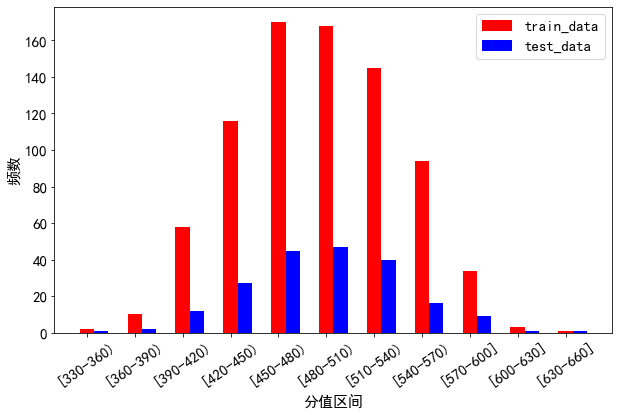

In [23]:
val_1 = ['[330-360)','[360-390)','[390-420)','[420-450)','[450-480)','[480-510)','[510-540)',
    '[540-570)','[570-600]','[600-630]','[630-660]']
plt.figure(figsize=(10,6))
bar_width = 0.3
fontsize_1 = 15
plt.bar(np.arange(1,len(total_raw)+1),total_raw,bar_width,color='red', label='train_data')
plt.bar(np.arange(1,len(total_raw)+1)+ bar_width,total_test,bar_width,color='blue', label='test_data') # 间隔一个 width 显示红蓝分布
plt.xticks(np.arange(1,len(total_raw)+1),val_1, fontsize=fontsize_1,rotation=35)
plt.yticks( fontsize=fontsize_1)
plt.xlabel('分值区间',fontsize=fontsize_1)
plt.ylabel('频数',fontsize=fontsize_1)
plt.legend(fontsize=fontsize_1)  
print('观察不同分数段内的样本分布,测试集和训练集在分布上区别不大')

#### <font color=blue>单调性指标 —> Kendall's Tau （ktau）</font>

In [24]:
# 计算单调性指标
def cal_kendall_tau(df_1,score_min,score_max,step,label='target'):
    score_bin = np.arange(score_min,score_max+step,step)
    bin_num = []
    for i in range(len(score_bin)-1):
        df_temp = df_1.loc[(df_1.score >= score_bin[i]) & (df_1.score < score_bin[i+1])]
        bin_num.append(df_temp[label].sum())
    concordant_pair = 0
    discordant_pair = 0
    for j in range(0, len(bin_num)-1):
        if bin_num[j] < bin_num[j+1]:
            discordant_pair += 1
        else:
            concordant_pair += 1
    ktau = (concordant_pair - discordant_pair) / (len(bin_num) * (len(bin_num) - 1) / 2)
    return ktau

In [25]:
ktau_train = cal_kendall_tau(df_train_score,330,660,30,label='target')
ktau_test = cal_kendall_tau(df_test_score,330,660,30,label='target')
print('训练集 ktau 值为 {0},\n测试集 ktau 值为 {1}'.format(ktau_train,ktau_test)) 

训练集 ktau 值为 0.07272727272727272,
测试集 ktau 值为 0.03636363636363636


由上可知，本例风控模型的训练集和测试集的分值区间分布非单调，训练集 ktau 值为 0.0727，测试集 ktau 值为 0.0363，远小于1。   

其主要原因为：样本在分值区间不是单调的，导致坏样本的分布也不是单调的。   

另外，原始样本数据仅1000条，模型拟合时没有设定分数阈值，而在实际处理大样本量时，可以设定分数阈值，将小于阈值的样本去掉后，再计算单调性。

#### <font color=blue>性能监控指标 —> KS、AR、AUC、Recall、Precision</font>

In [26]:
# 计算混淆矩阵cnf_matrix、召回率recall、精准率precision、模型预测的准确率accuracy_score（AR）

# 训练集
cnf_matrix_train = pd.DataFrame(data=confusion_matrix(y_train, y_pred_train),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value_train = recall_score(y_train, y_pred_train)
precision_value_train = precision_score(y_train, y_pred_train)
acc_train = accuracy_score(y_train, y_pred_train)

# 测试集
cnf_matrix_test = pd.DataFrame(data=confusion_matrix(y_test, y_pred_test),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value_test = recall_score(y_test, y_pred_test)
precision_value_test = precision_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, y_pred_test)

print('训练集的 Recall 召回率：',recall_value_train,'\n测试集的 Recall 召回率：',recall_value_test)
print('='*80)
print('训练集的 Precision 精准率：',precision_value_train,'\n测试集的 Precision 精准率：',precision_value_test)
print('='*80)
print('训练集预测的 AR 正确率:',acc_train,'\n测试集预测的 AR 正确率:',acc_test)

训练集的 Recall 召回率： 0.8375 
测试集的 Recall 召回率： 0.7333333333333333
训练集的 Precision 精准率： 0.5491803278688525 
测试集的 Precision 精准率： 0.4943820224719101
训练集预测的 AR 正确率: 0.745 
测试集预测的 AR 正确率: 0.695


In [27]:
print('训练集的混淆矩阵：')
cnf_matrix_train

训练集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,395,165
真实样本为反例,39,201


In [28]:
print('测试集的混淆矩阵：')
cnf_matrix_test

测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,95,45
真实样本为反例,16,44


In [29]:
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
train_precision, train_recall, _ = precision_recall_curve(y_train, y_score_train)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_score_test)

训练集 vs 测试集的 P-R 曲线：


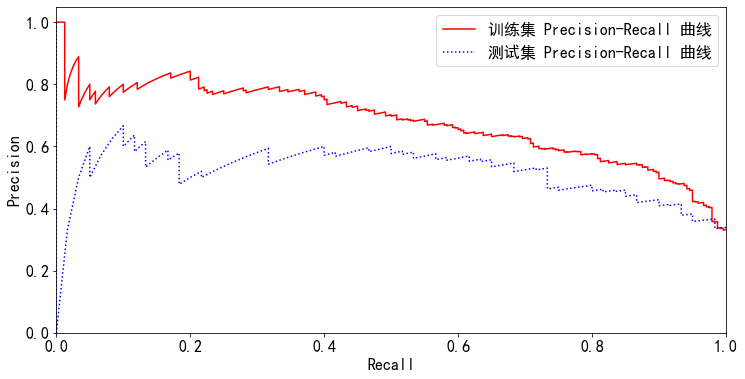

In [30]:
plt.figure(figsize=(12,6))  
plt.plot(train_recall, train_precision,color = 'r', linestyle='-',label='训练集 Precision-Recall 曲线')
plt.plot(test_recall, test_precision,color = 'b', linestyle=':',label='测试集 Precision-Recall 曲线')
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
print('训练集 vs 测试集的 P-R 曲线：')

In [31]:
# 计算 FPR 与 TPR
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_score_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)

# 计算 AUC 值
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

ar_train = 2*roc_auc_train-1
ar_test = 2*roc_auc_test-1

# 计算 KS 值
ks_train = max(tpr_train - fpr_train)
ks_test = max(tpr_test - fpr_test)

print('训练集的 AUC 值：',roc_auc_train,'\n测试集的 AUC 值：',roc_auc_test)
print('='*80)
print('训练集的 AR 值：',ar_train,'\n测试集的 AR 值：',ar_test)
print('='*80)
print('训练集最大 KS 值:',acc_train,'\n测试集最大 KS 值:',acc_test)

训练集的 AUC 值： 0.8480580357142857 
测试集的 AUC 值： 0.7702380952380953
训练集的 AR 值： 0.6961160714285715 
测试集的 AR 值： 0.5404761904761906
训练集最大 KS 值: 0.745 
测试集最大 KS 值: 0.695


Text(0.5, 1.0, '测试集洛伦兹曲线')

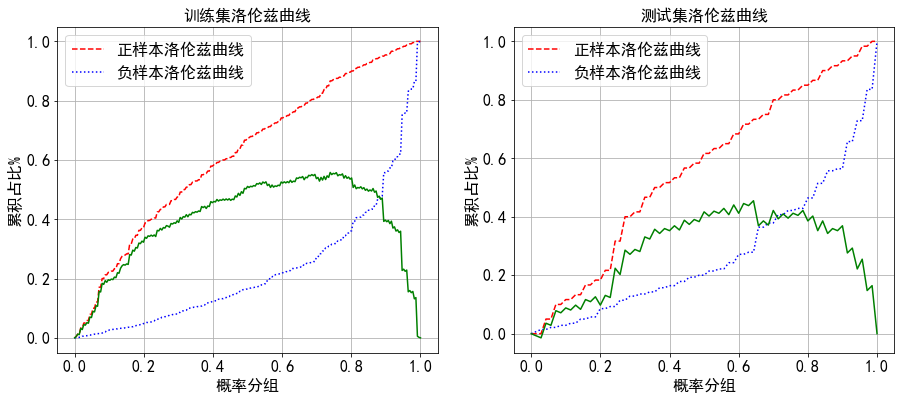

In [32]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,1,len(tpr_train)),tpr_train,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr_train)),fpr_train,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr_train)),tpr_train - fpr_train,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
plt.title( '训练集洛伦兹曲线',fontsize=16)

plt.subplot(1,2,2)
plt.plot(np.linspace(0,1,len(tpr_test)),tpr_test,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr_test)),fpr_test,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr_test)),tpr_test - fpr_test,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
plt.title( '测试集洛伦兹曲线',fontsize=16)

关于性能监控指标 —> KS、AR、AUC、Recall、Precision、洛伦兹曲线 等指标的具体说明，请见本系列代码实现《步骤5：logistic逻辑回归模型》。